In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import sys
import warnings
import gc
import random
import numpy as np
random.seed(113347)
np.random.seed(565)
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.color import rgb2gray
from skimage.morphology import label
from scipy import ndimage as ndi
import zipfile

from keras.models import Model, load_model
from keras.layers import Input, Dropout, BatchNormalization, Add, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Activation, ZeroPadding2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)

# Set some parameters
BS = 32
EPOCHS_1 = 40
EPOCHS_2 = 200
ORI_D = 101
TRAIN_ZIP = '../input/train.zip'
TEST_ZIP = '../input/test.zip'
TRAIN_PATH = '../input/train/'
TEST_PATH = '../input/test/'
TRAIN_CSV = '../input/train.csv'
DEPTH_CSV = '../input/depths.csv'

if not os.path.exists(TRAIN_PATH):
    zip_ref = zipfile.ZipFile(TRAIN_ZIP, 'r')
    zip_ref.extractall(TRAIN_PATH)
    zip_ref.close()
if not os.path.exists(TEST_PATH):
    zip_ref = zipfile.ZipFile(TEST_ZIP, 'r')
    zip_ref.extractall(TEST_PATH)
    zip_ref.close()
if not os.path.exists('./models'):
    os.makedirs('./models')
print(os.listdir(TRAIN_PATH))

Using TensorFlow backend.


['masks', 'images']


In [2]:
def rle_encoding(x, order='F', to_str=True):
    dots = np.where(x.flatten(order=order) == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    if to_str:
        return ' '.join(str(y) for y in run_lengths)
    return run_lengths


In [3]:
train_csv = pd.read_csv(TRAIN_CSV)
depth_csv = pd.read_csv(DEPTH_CSV)
test_csv = depth_csv[~depth_csv.index.isin(train_csv.index)]
del depth_csv
gc.collect()

7

In [4]:
X_train = []
Y_train = [] 

print('Getting train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_csv.id), total=len(train_csv.id)):
    path = TRAIN_PATH
    img = imread(path + 'images/' + id_ + '.png')[...,0].astype(np.uint8)
    assert img.ndim==2
    assert img.shape[0]==ORI_D and img.shape[1]==ORI_D
    X_train.append(img)
    mask = np.squeeze(imread(path + 'masks/' + id_ + '.png')>0).astype(np.uint8)
    assert mask.ndim==2
    Y_train.append(mask)
del img, mask
gc.collect()

Getting train images and masks ... 


100%|██████████| 4000/4000 [00:01<00:00, 2040.43it/s]


0

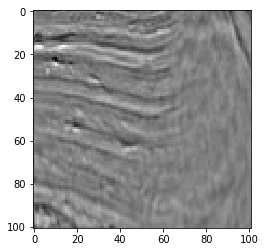

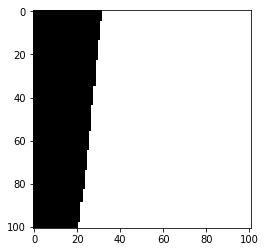

In [5]:
# Check if training data looks all right
ix = np.random.randint(0, len(train_csv.id))
plt.imshow(X_train[ix], cmap='gray')
plt.show()
plt.imshow(Y_train[ix], cmap='gray')
plt.show()

In [6]:
def custom_loss(y_true, y_pred_):
    
    y_pred = K.sigmoid(y_pred_)
    
    def dice_coef(y_true, y_pred): 
        return (2.* K.sum(y_true*y_pred) + 1) / (K.sum(y_true) + K.sum(y_pred) + 1) # scaler
    
    s_dice_coef = dice_coef(y_true, y_pred) # scaler
    s_bce = K.mean(K.binary_crossentropy(y_true, y_pred)) # scaler
    loss = 0.5*s_bce - s_dice_coef + 1. # scaler [0, inf)
    
    return loss # scaler [0, inf)

In [7]:
# Define IoU metric
def score_numpy(Ys, Ps, th=0.0):
    iou_ths = np.arange(0.0, 1.0, 0.05)
    Ps = Ps.reshape(Ps.shape[0], -1).copy()
    Ys = Ys.reshape(Ys.shape[0], -1).copy()
    for n, P in enumerate(Ps):
        Ps[n] = P>th
    Ps = Ps.astype(np.bool)
    Ys = Ys.astype(np.bool)
    TPs = np.zeros_like(iou_ths, dtype=np.float32)
    FPs = np.zeros_like(iou_ths, dtype=np.float32)
    FNs = np.zeros_like(iou_ths, dtype=np.float32)
    for Y, P in zip(Ys, Ps):
        iou = (Y&P).sum() / ((Y|P).sum()+1e-9)
        Y_sum = Y.sum()
        P_sum = P.sum()
        for n, iou_th in enumerate(iou_ths):
            if iou>=iou_th: # TP
                TPs[n]+=1
            elif Y_sum<=0 and P_sum>0: # FP
                FPs[n]+=1
            elif Y_sum>0 and P_sum<=0: # FN
                FNs[n]+=1
    return np.mean(TPs / (TPs+FPs+FNs))

def score(label, pred):
    metric_value = tf.py_func(score_numpy, [label, pred], tf.float32)
    return metric_value

In [8]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

In [9]:
def build_model():
    def conv(f, k=3, act='relu'):
        return Conv2D(f, (k, k), activation=act, kernel_initializer='he_normal', padding='same')
    def _res_conv(inputs, f, k=3): # very simple residual module
        channels = int(inputs.shape[-1])
        
        cs = inputs
        
        cs = BatchNormalization() (cs)
        cs = Activation('relu') (cs)
        cs = conv(f, 3, act=None) (cs)
        
        cs = Dropout(0.2) (cs)
        
        cs = BatchNormalization() (cs)
        cs = Activation('relu') (cs)
        cs = conv(f, 3, act=None) (cs)
        
        if f!=channels:
            t1 = conv(f, 1, None) (inputs) # identity mapping
        else:
            t1 = inputs
        
        out = Add()([t1, cs]) # t1 + c2
        return out
    def pool():
        return MaxPooling2D((2, 2))
    def up(inputs, pad='same'):
        upsampled = Conv2DTranspose(int(inputs.shape[-1]), (3, 3), strides=(2, 2), kernel_initializer='he_normal', padding=pad) (inputs)
        return upsampled
    
    inputs = Input(shape=(ORI_D, ORI_D, 1))
    preprocess1 = Lambda(lambda x: x/255.0) (inputs)
    
    r = 16
    rep = 4
    mid_rep = 3
    x = preprocess1
    
    skip_connections = []
    pad_mode = ['same', 'valid', 'same', 'valid']
    
    for t in range(rep):
        x = conv(r*int(2**t), 3, None) (x)
        x = _res_conv(x, r*int(2**t), 3)
        x = _res_conv(x, r*int(2**t), 3)
        x = BatchNormalization() (x)
        x = Activation('relu') (x)
        skip_connections.append(x)
        x = pool() (x)
    
    x = conv(r*int(2**rep), 3, None) (x)
    for t in range(mid_rep):
        x = _res_conv(x, r*int(2**rep))
    
    for t, s, p in zip(reversed(range(rep)), reversed(skip_connections), pad_mode):
        x = BatchNormalization() (x)
        x = Activation('relu') (x)
        x = up(x, p)
        x = concatenate([s, x])
        x = conv(r*int(2**t), 3, None) (x)
        x = _res_conv(x, r*int(2**t), 3)
        x = _res_conv(x, r*int(2**t), 3)
    x = BatchNormalization() (x)
    x = Activation('relu') (x)
    outputs = Conv2D(1, (1, 1), activation=None, kernel_initializer='he_normal', padding='valid') (x)
    return Model([inputs], [outputs])

In [10]:
model = build_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 101, 101, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 101, 101, 16) 160         lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 101, 101, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [11]:
from keras.utils import Sequence
import cv2
from sklearn.utils import shuffle
from skimage.transform import AffineTransform, warp
import copy
import imgaug as ia
from imgaug import augmenters as iaa

class data_generator(Sequence):
    def __init__(self, data, label, batch_size=4, training=True):
        self.data = data
        self.label= label
        self.batch_size = batch_size
        self.training = training
        self.seq_color = iaa.Sequential(
            [
                iaa.SomeOf((0, 2),
                    [
                        iaa.Dropout((0.01, 0.1)),
                        iaa.ContrastNormalization((0.95, 1.05)),
                        
                    ], random_order=True
                )
            ], random_order=True
        )
    def __len__(self):
        return int(np.ceil(float(len(self.data))/self.batch_size))
    def on_epoch_end(self):
        if self.training: self.data, self.label = shuffle(self.data, self.label)
    def __getitem__(self, i):
        l_bound =  i    * self.batch_size
        r_bound = (i+1) * self.batch_size
        if r_bound>len(self.data): # ensure every iteration has the same batch size
            r_bound = len(self.data)
            l_bound = r_bound - self.batch_size
        dat_que = np.empty((self.batch_size, ORI_D, ORI_D, 1), dtype=np.uint8)
        lab_que = np.empty((self.batch_size, ORI_D, ORI_D, 1), dtype=np.uint8)
        for n, index in enumerate(range(l_bound, r_bound)):
            img = copy.deepcopy(self.data[index]).astype(np.float32) / 255.
            lab = copy.deepcopy(self.label[index]).astype(np.float32)
            if self.training:
                if np.random.rand() < .5: # flip horizontal
                    img = np.flip(img, 1)
                    lab = np.flip(lab, 1)

                if np.random.rand()<0.2:
                    a = .02 # amptitude
                    t  = np.random.uniform(1-a,1+a)
                    img = np.clip(img * t, 0, 1) # channel wise amplify
                
                if np.random.rand()<0.2:
                    up = np.random.uniform(0.975, 1.025) # change gamma
                    img = np.clip(img**up, 0, 1) # apply gamma and convert back to range [0,255]
                
                if np.random.rand()<0.3:
                    sigma = np.random.rand()*0.02
                    img = np.clip(img + np.random.randn(*img.shape)*sigma, 0, 1)
                
                if np.random.rand() < 0.4:
                    crop_ratio = np.random.uniform(0.01, 0.15, size=4)
                    u, r, d, l = np.round(crop_ratio * np.array([img.shape[0], img.shape[1]]*2)).astype(np.uint8)
                    img = img[u:-d,l:-r] # crop image
                    lab = lab[u:-d,l:-r] # crop image
                
                if np.random.rand() < 0.3:
                    img = np.clip(self.seq_color.augment_image(img), 0, 1)
            ### end of data augmentation ###

            img = np.clip(img.astype(np.float32)*255,0, 255).astype(np.uint8)
            lab = np.round(np.clip(lab.astype(np.float32),0, 1)).astype(np.uint8)
            
            if img.shape[0]!=ORI_D or img.shape[1]!=ORI_D:
                diffr = ORI_D-img.shape[0] # must >= 0
                diffc = ORI_D-img.shape[1] # must >= 0
                padr1 = np.random.randint(diffr+1)
                padr2 = diffr-padr1
                padc1 = np.random.randint(diffc+1)
                padc2 = diffc-padc1
                img = np.pad(img, ((padr1,padr2),(padc1,padc2)), 'wrap')
                lab = np.pad(lab, ((padr1,padr2),(padc1,padc2)), 'wrap')

            dat_que[n,...,0] = img
            lab_que[n,...,0] = lab
        return dat_que, lab_que

In [12]:
coverage = np.asarray([ x.sum() / (ORI_D**2) for x in Y_train ])
coverage_lev = np.linspace(0, 1, 30)
import bisect
coverage_stratify = []
for cov in coverage:
    coverage_stratify.append(bisect.bisect_left(coverage_lev, cov))

In [13]:
# https://www.surveysystem.com/sscalc.htm
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=600, shuffle=True, stratify = coverage_stratify)
del coverage, coverage_lev, coverage_stratify

In [14]:
train_generator = data_generator(X_train, Y_train, batch_size=BS, training=True)

In [15]:
import multiprocessing
from keras.optimizers import Adam
checkpointer_best = ModelCheckpoint('./models/best.h5', monitor='val_score', mode='max', verbose=1, save_best_only=True)

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=2, min_lr=0.00001, mode='min')
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=10)
model.compile(loss=custom_loss, optimizer=Adam(lr=0.001), metrics=[score])
history = model.fit_generator(train_generator,
                              steps_per_epoch= len(train_generator), 
                              epochs=EPOCHS_1, 
                              validation_data=(np.asarray(X_val)[...,np.newaxis], np.asarray(Y_val)[...,np.newaxis]), 
                              callbacks=[checkpointer_best, reduce_lr, early_stop],
                              workers= max(1, multiprocessing.cpu_count()-3),
                              use_multiprocessing= True,
                              shuffle = True
                              )

Epoch 1/40
107/107 [==============================] - 22s 208ms/step - loss: 0.8759 - score: 0.3419 - val_loss: 1.8163 - val_score: 0.5191

Epoch 00001: val_score improved from -inf to 0.51905, saving model to ./models/best.h5
Epoch 2/40
107/107 [==============================] - 14s 127ms/step - loss: 0.6685 - score: 0.4392 - val_loss: 1.1768 - val_score: 0.5875

Epoch 00002: val_score improved from 0.51905 to 0.58755, saving model to ./models/best.h5
Epoch 3/40
107/107 [==============================] - 14s 128ms/step - loss: 0.6391 - score: 0.4486 - val_loss: 1.0312 - val_score: 0.5249

Epoch 00003: val_score did not improve from 0.58755
Epoch 4/40
107/107 [==============================] - 14s 127ms/step - loss: 0.5986 - score: 0.4632 - val_loss: 0.9899 - val_score: 0.5944

Epoch 00004: val_score improved from 0.58755 to 0.59444, saving model to ./models/best.h5
Epoch 5/40
107/107 [==============================] - 14s 127ms/step - loss: 0.6025 - score: 0.4640 - val_loss: 0.6431 - 

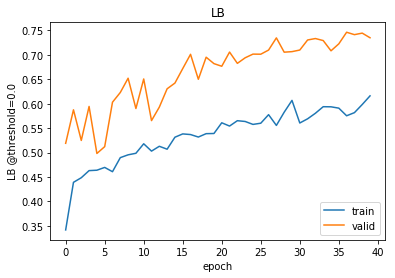

In [17]:
plt.plot(history.history['score'])
plt.plot(history.history['val_score'])
plt.title('LB')
plt.ylabel('LB @threshold=0.0')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='lower right')
plt.show()

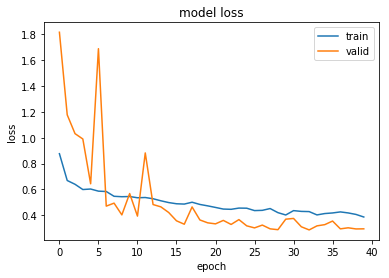

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper right')
plt.show()

In [19]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=2, min_lr=0.00001, mode='min')
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=10)
model.compile(loss=lovasz_loss, optimizer=Adam(lr=0.001), metrics=[score])
history = model.fit_generator(train_generator,
                              steps_per_epoch= len(train_generator), 
                              epochs=EPOCHS_2, 
                              validation_data=(np.asarray(X_val)[...,np.newaxis], np.asarray(Y_val)[...,np.newaxis]), 
                              callbacks=[checkpointer_best, reduce_lr, early_stop],
                              workers= max(1, multiprocessing.cpu_count()-3),
                              use_multiprocessing= True,
                              shuffle = True
                              )

Epoch 1/200
107/107 [==============================] - 48s 450ms/step - loss: 0.8045 - score: 0.5476 - val_loss: 1.4732 - val_score: 0.4050

Epoch 00001: val_score did not improve from 0.74622
Epoch 2/200
107/107 [==============================] - 40s 374ms/step - loss: 0.7341 - score: 0.5514 - val_loss: 0.7036 - val_score: 0.6660

Epoch 00002: val_score did not improve from 0.74622
Epoch 3/200
107/107 [==============================] - 40s 373ms/step - loss: 0.7042 - score: 0.5617 - val_loss: 0.5901 - val_score: 0.6978

Epoch 00003: val_score did not improve from 0.74622
Epoch 4/200
107/107 [==============================] - 40s 373ms/step - loss: 0.7057 - score: 0.5458 - val_loss: 0.6778 - val_score: 0.6622

Epoch 00004: val_score did not improve from 0.74622
Epoch 5/200
107/107 [==============================] - 40s 373ms/step - loss: 0.7320 - score: 0.5319 - val_loss: 0.7426 - val_score: 0.7076

Epoch 00005: val_score did not improve from 0.74622
Epoch 6/200
107/107 [==============

107/107 [==============================] - 40s 373ms/step - loss: 0.5906 - score: 0.6216 - val_loss: 0.3844 - val_score: 0.8009

Epoch 00042: val_score did not improve from 0.82354
Epoch 43/200
107/107 [==============================] - 40s 373ms/step - loss: 0.5838 - score: 0.6248 - val_loss: 0.4298 - val_score: 0.7813

Epoch 00043: val_score did not improve from 0.82354
Epoch 44/200
107/107 [==============================] - 40s 373ms/step - loss: 0.5953 - score: 0.6185 - val_loss: 0.3894 - val_score: 0.8083

Epoch 00044: val_score did not improve from 0.82354
Epoch 45/200
107/107 [==============================] - 40s 373ms/step - loss: 0.5948 - score: 0.6298 - val_loss: 0.4125 - val_score: 0.7882

Epoch 00045: val_score did not improve from 0.82354
Epoch 46/200
107/107 [==============================] - 40s 373ms/step - loss: 0.6188 - score: 0.6058 - val_loss: 0.3987 - val_score: 0.7892

Epoch 00046: val_score did not improve from 0.82354
Epoch 47/200
107/107 [=====================

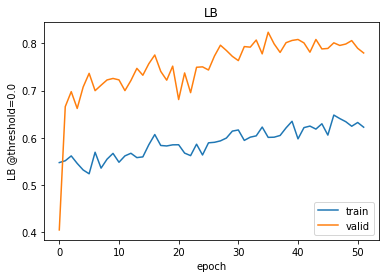

In [20]:
plt.plot(history.history['score'])
plt.plot(history.history['val_score'])
plt.title('LB')
plt.ylabel('LB @threshold=0.0')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='lower right')
plt.show()

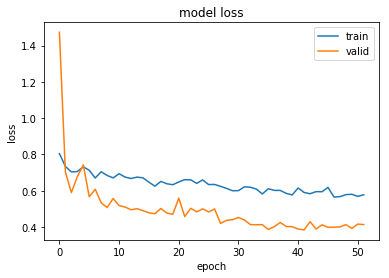

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper right')
plt.show()

In [22]:
model.load_weights('./models/best.h5')
preds_val = model.predict(np.asarray(X_val)[...,np.newaxis], batch_size=BS, verbose=1)

600/600 [==============================] - 2s 3ms/step


In [23]:
threshold_choices = np.linspace(-0.1, 0.1, 200)
best_threshold = 0.1
best_score = 0

for th in threshold_choices:
    Ys = np.squeeze(Y_val)
    Ps = np.squeeze(preds_val)
    score = score_numpy(Ys, Ps, th)
    #print('score: {:.4f} @threshold: {:.2f}'.format(score, th))
    if score>best_score:
        best_score = score
        best_threshold = th
print('best threshold: {:.2f}, best score: {:.8f}'.format(best_threshold, best_score))


best threshold: -0.09, best score: 0.83040315


277


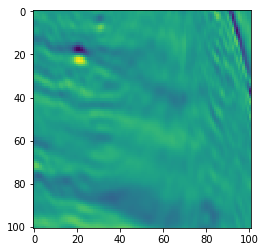

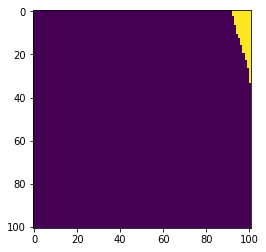

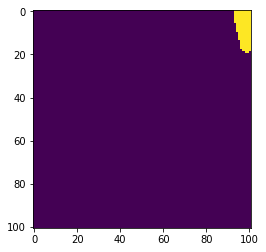

In [24]:
# Perform a sanity check on some random training samples
ix = np.random.randint(0, len(preds_val))
print(ix)
shape = Y_val[ix].shape[:2]
plt.imshow(X_val[ix])
plt.show()
plt.imshow(Y_val[ix])
plt.show()
preds = np.squeeze(preds_val[ix])
preds = preds>best_threshold
plt.imshow(preds)
plt.show()

In [25]:
del X_train, Y_train
gc.collect()

141620

In [26]:
sub_rles = []
x_test = []
print('Reading testing data...')
for n, id_ in tqdm(enumerate(test_csv.id), total=len(test_csv.id)):
    path = TEST_PATH
    img = imread(path + 'images/' + id_ + '.png')[...,0].astype(np.uint8)[...,np.newaxis]
    x_test.append(img)

print('Predicting...')
preds = model.predict(np.asarray(x_test), batch_size=BS, verbose=1)[...,0]
print('Convert to RLE...')
for pred in tqdm(preds, total=len(preds)):
    pred_thresholded = (pred>best_threshold).astype(np.bool)
    rle = rle_encoding(pred_thresholded)
    sub_rles.append(rle)
sub = pd.DataFrame()
sub['id'] = test_csv.id
sub['rle_mask'] = sub_rles
sub.to_csv('salty.csv', index=False)
print('Done!')

  2%|▏         | 270/18000 [00:00<00:06, 2699.42it/s]

Reading testing data...


100%|██████████| 18000/18000 [00:05<00:00, 3029.60it/s]


Predicting...
18000/18000 [==============================] - 19s 1ms/step


  0%|          | 0/18000 [00:00<?, ?it/s]

Convert to RLE...


100%|██████████| 18000/18000 [00:09<00:00, 1906.91it/s]

Done!
